In [ ]:
from google.cloud import storage
from google.colab import auth
import pandas as pd
from IPython.display import Image
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
from torch.utils.data import Dataset
from torchvision import transforms, utils, models
from PIL import Image
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [ ]:
# Authenticate with Google Cloud
auth.authenticate_user()

# Instantiates a client
storage_client = storage.Client()

# Access bucket
existing_bucket_name = "thoraticdiseasedataset"
bucket = storage_client.get_bucket(existing_bucket_name)
print(f"Accessed bucket {bucket.name}.")



Accessed bucket thoraticdiseasedataset.


In [ ]:
# Load CSV
csv_path = "Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/train_visualCheXbert.csv"
blob = bucket.blob(csv_path)
df = pd.read_csv(io.StringIO(blob.download_as_text()))
df.head()
#df.dtypes

,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Diagnosis Columns
diagnosis_cols = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", "Edema",
    "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
]
# print type
print(df.dtypes)

Path                           object
Sex                            object
Age                             int64
Frontal/Lateral                object
AP/PA                          object
Enlarged Cardiomediastinum    float64
Cardiomegaly                  float64
Lung Opacity                  float64
Lung Lesion                   float64
Edema                         float64
Consolidation                 float64
Pneumonia                     float64
Atelectasis                   float64
Pneumothorax                  float64
Pleural Effusion              float64
Pleural Other                 float64
Fracture                      float64
Support Devices               float64
No Finding                    float64
dtype: object


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal/Lateral             223414 non-null  object 
 4   AP/PA                       191027 non-null  object 
 5   Enlarged Cardiomediastinum  223414 non-null  float64
 6   Cardiomegaly                223414 non-null  float64
 7   Lung Opacity                223414 non-null  float64
 8   Lung Lesion                 223414 non-null  float64
 9   Edema                       223414 non-null  float64
 10  Consolidation               223414 non-null  float64
 11  Pneumonia                   223414 non-null  float64
 12  Atelectasis                 223414 non-null  float64
 13  Pneumothorax  

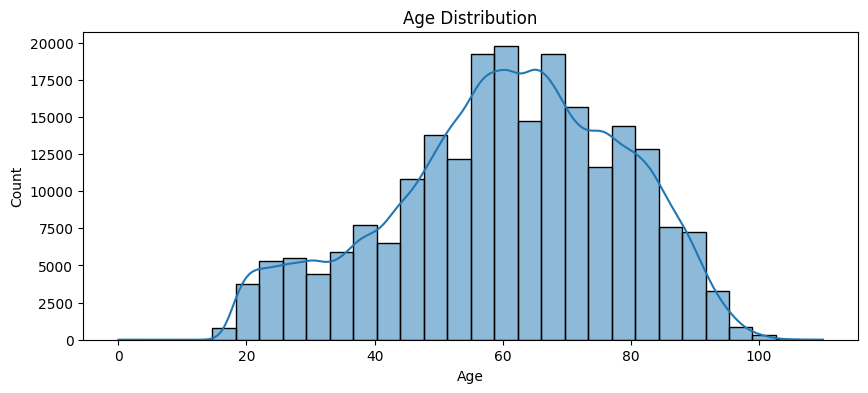

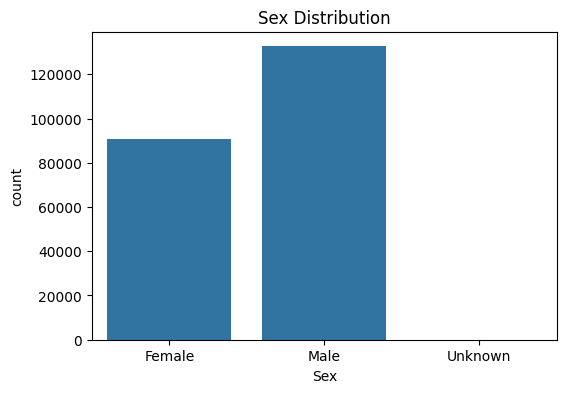

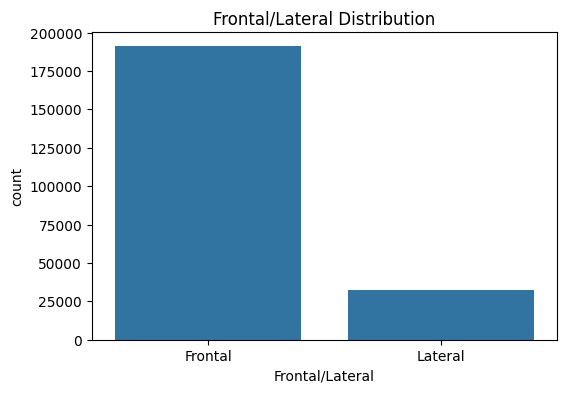

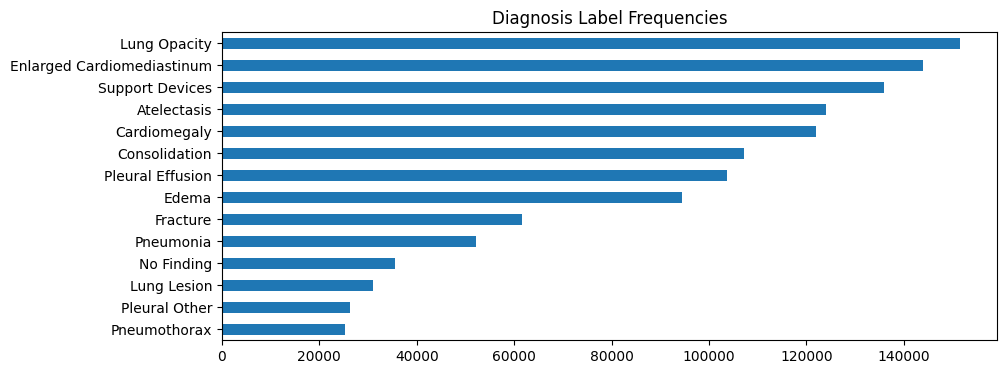

In [ ]:
# Intitial Data Visualization
print(df.info())
print(df.describe(include='all'))

# Age Distribution
plt.figure(figsize=(10,4))
sns.histplot(df["Age"].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

#Sex Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Sex", data=df)
plt.title("Sex Distribution")
plt.show()

#Frontal/Lateral Xray Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Frontal/Lateral", data=df)
plt.title("Frontal/Lateral Distribution")
plt.show()

# Diagnosis Frequency
plt.figure(figsize=(10,4))
df[diagnosis_cols].sum().sort_values().plot(kind='barh')
plt.title("Diagnosis Label Frequencies")
plt.show()

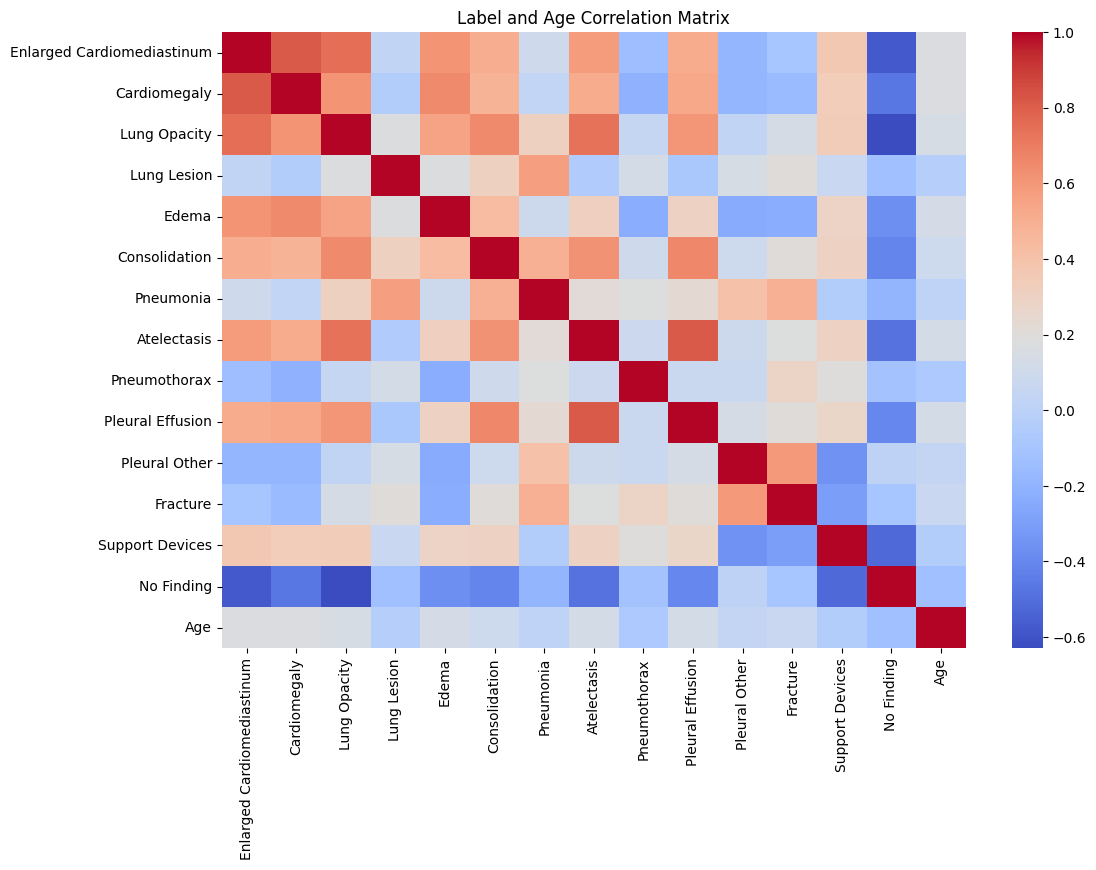

In [ ]:
# Correlations
corr_matrix = df[diagnosis_cols + ["Age"]].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Label and Age Correlation Matrix")
plt.show()

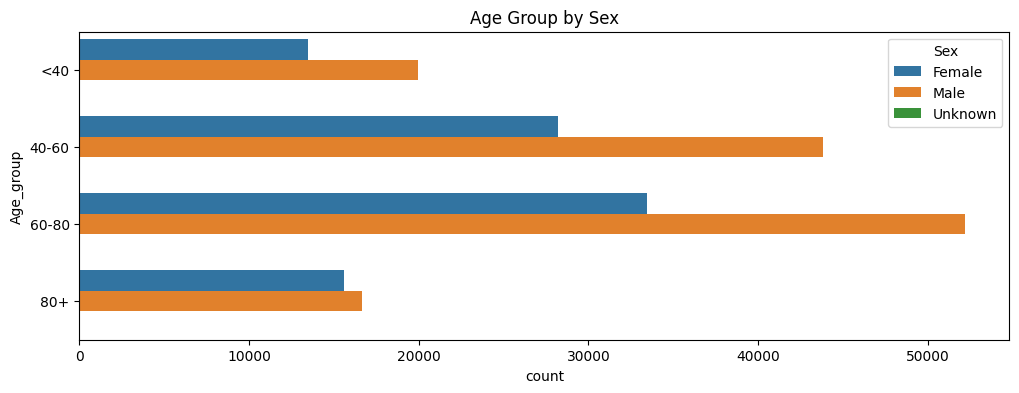

In [ ]:
# Attribute Engineering
df['Age_group'] = pd.cut(df['Age'], bins=[0, 40, 60, 80, 120], labels=['<40','40-60','60-80','80+'])
df['View_Combo'] = df['Frontal/Lateral'].astype(str) + "_" + df['AP/PA'].fillna("Unknown").astype(str)

# Composite bar plot example
plt.figure(figsize=(12,4))
sns.countplot(y="Age_group", hue="Sex", data=df)
plt.title("Age Group by Sex")
plt.show()

Missing values per column:
 Path                              0
Sex                               0
Age                               0
Frontal/Lateral                   0
AP/PA                         32387
Enlarged Cardiomediastinum        0
Cardiomegaly                      0
Lung Opacity                      0
Lung Lesion                       0
Edema                             0
Consolidation                     0
Pneumonia                         0
Atelectasis                       0
Pneumothorax                      0
Pleural Effusion                  0
Pleural Other                     0
Fracture                          0
Support Devices                   0
No Finding                        0
Age_group                         3
View_Combo                        0
dtype: int64


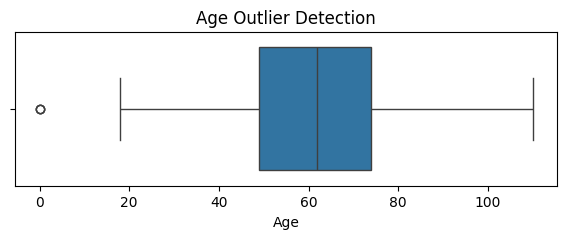

Preprocessing complete. Sample of processed dataframe:
                                                Path   Age  \
0  CheXpert-v1.0/train/patient00001/study1/view1_...  68.0   
1  CheXpert-v1.0/train/patient00002/study2/view1_...  87.0   
2  CheXpert-v1.0/train/patient00002/study1/view1_...  83.0   
3  CheXpert-v1.0/train/patient00002/study1/view2_...  83.0   
4  CheXpert-v1.0/train/patient00003/study1/view1_...  41.0   

   Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  Lung Lesion  Edema  \
0                           0             0             0            0      0   
1                           1             1             1            0      1   
2                           1             1             1            1      0   
3                           1             1             1            1      0   
4                           1             1             1            0      1   

   Consolidation  Pneumonia  Atelectasis  ...  AP/PA_PA  AP/PA_RL  \
0              0

In [ ]:
# Missing Value Evaluation
print("Missing values per column:\n", df.isnull().sum())
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Sex'] = df['Sex'].fillna('Unknown')
df['Frontal/Lateral'] = df['Frontal/Lateral'].fillna('Unknown')
df['AP/PA'] = df['AP/PA'].fillna('Unknown')
df[diagnosis_cols] = df[diagnosis_cols].fillna(0).astype('int')


# Outlier handling for Age
plt.figure(figsize=(7,2))
sns.boxplot(x=df["Age"])
plt.title("Age Outlier Detection")
plt.show()
df = df[(df["Age"] >= 18) & (df["Age"] <= 100)]  # Cap age to plausible range

# Feature Scaling
scaler = StandardScaler()
df["Age_scaled"] = scaler.fit_transform(df[["Age"]])

# Encoding Categorical Features
df = pd.get_dummies(df, columns=["Sex", "Frontal/Lateral", "AP/PA", "Age_group", "View_Combo"], drop_first=True)


# Convert Booleans into float32
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
col_to_convert = bool_cols + ['Age']
df[col_to_convert] = df[col_to_convert].astype('float32')

# Dimensionality Reduction
meta_features = df.drop(columns=["Path"] + diagnosis_cols)
pca = PCA(n_components=5)
meta_pca = pca.fit_transform(meta_features)

print("Preprocessing complete. Sample of processed dataframe:")
print(df.head())

In [ ]:
#target variable 'Cardiomegaly'

# Define features and target
X = df.drop(columns=['Cardiomegaly', 'Path'])  # Drop target and Path
Y = df['Cardiomegaly']

# Split the Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Full Feature Model
model_full = LogisticRegression(max_iter=1000)
model_full.fit(X_train, Y_train)

# Feature Selection using RFE
selector = RFE(model_full, n_features_to_select=10)  # select top 10 features
selector = selector.fit(X_train, Y_train)

# Reduced feature set
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# Model with reduced features
model_reduced = LogisticRegression(max_iter=1000)
model_reduced.fit(X_train_reduced, Y_train)

# Save models
pickle.dump(model_full, open('finalized_model_full.model', 'wb'))
pickle.dump(model_reduced, open('finalized_model_reduced.model', 'wb'))

# Load and test saved models
loaded_full = pickle.load(open('finalized_model_full.model', 'rb'))
loaded_reduced = pickle.load(open('finalized_model_reduced.model', 'rb'))

print("Full model accuracy:", loaded_full.score(X_test, Y_test))
print("Reduced model accuracy:", loaded_reduced.score(X_test_reduced, Y_test))

Full model accuracy: 0.9243981636994737
Reduced model accuracy: 0.9259209495017355


In [24]:
# Full Feature Model
rf_model_full = RandomForestClassifier(random_state=42)
rf_model_full.fit(X_train, Y_train)

# Model with reduced features
rf_model_reduced = RandomForestClassifier(random_state=42)
rf_model_reduced.fit(X_train_reduced, Y_train)

# Save models
pickle.dump(rf_model_full, open('rf_model_full.model', 'wb'))
pickle.dump(rf_model_reduced, open('rf_model_reduced.model', 'wb'))

# Load and test saved models
loaded_rf_full = pickle.load(open('rf_model_full.model', 'rb'))
loaded_rf_reduced = pickle.load(open('rf_model_reduced.model', 'rb'))

print("Random Forest full model accuracy:", loaded_rf_full.score(X_test, Y_test))
print("Random Forest reduced model accuracy:", loaded_rf_reduced.score(X_test_reduced, Y_test))

Random Forest full model accuracy: 0.9193819281155525
Random Forest reduced model accuracy: 0.9263240398611577


In [ ]:
# Random Forest with Full Features and hyperparameters
print("Training Random Forest with full features...")
rf_model_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model_full.fit(X_train, Y_train)

# Random Forest with Reduced Features and hyperparameters
print("Training Random Forest with reduced features...")
rf_model_reduced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model_reduced.fit(X_train_reduced, Y_train)

# Evaluate Full Random Forest Model
print("\n=== Random Forest (Full Features) ===")
y_pred_full = rf_model_full.predict(X_test)
y_pred_proba_full = rf_model_full.predict_proba(X_test)[:, 1]

print(f"Accuracy: {rf_model_full.score(X_test, Y_test):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(Y_test, y_pred_proba_full):.4f}")
print("\nClassification Report:")
print(classification_report(Y_test, y_pred_full))

# Evaluate Reduced Random Forest Model
print("\n=== Random Forest (Reduced Features) ===")
y_pred_reduced = rf_model_reduced.predict(X_test_reduced)
y_pred_proba_reduced = rf_model_reduced.predict_proba(X_test_reduced)[:, 1]

print(f"Accuracy: {rf_model_reduced.score(X_test_reduced, Y_test):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(Y_test, y_pred_proba_reduced):.4f}")
print("\nClassification Report:")
print(classification_report(Y_test, y_pred_reduced))

Training Random Forest with full features...
Training Random Forest with reduced features...

=== Random Forest (Full Features) ===
Accuracy: 0.9270
ROC-AUC Score: 0.9774

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92     20189
           1       0.91      0.96      0.94     24466

    accuracy                           0.93     44655
   macro avg       0.93      0.92      0.93     44655
weighted avg       0.93      0.93      0.93     44655


=== Random Forest (Reduced Features) ===
Accuracy: 0.9247
ROC-AUC Score: 0.9765

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     20189
           1       0.91      0.95      0.93     24466

    accuracy                           0.92     44655
   macro avg       0.93      0.92      0.92     44655
weighted avg       0.93      0.92      0.92     44655



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

# XGBoost - Full Features
xgb_model_full = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=len(Y_train[Y_train==0])/len(Y_train[Y_train==1])
)
xgb_model_full.fit(X_train, Y_train)

# XGBoost - Reduced Features
xgb_model_reduced = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    scale_pos_weight=len(Y_train[Y_train==0])/len(Y_train[Y_train==1])
)
xgb_model_reduced.fit(X_train_reduced, Y_train)

# LightGBM - Full Features
lgbm_model_full = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    class_weight='balanced',
    verbose=-1
)
lgbm_model_full.fit(X_train, Y_train)

# LightGBM - Reduced Features
lgbm_model_reduced = LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    class_weight='balanced',
    verbose=-1
)
lgbm_model_reduced.fit(X_train_reduced, Y_train)

# Sklearn Gradient Boosting - Full Features
gb_model_full = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model_full.fit(X_train, Y_train)

# Sklearn Gradient Boosting - Reduced Features
gb_model_reduced = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model_reduced.fit(X_train_reduced, Y_train)

# Save models
pickle.dump(xgb_model_full, open('xgb_model_full.model', 'wb'))
pickle.dump(xgb_model_reduced, open('xgb_model_reduced.model', 'wb'))
pickle.dump(lgbm_model_full, open('lgbm_model_full.model', 'wb'))
pickle.dump(lgbm_model_reduced, open('lgbm_model_reduced.model', 'wb'))
pickle.dump(gb_model_full, open('gb_model_full.model', 'wb'))
pickle.dump(gb_model_reduced, open('gb_model_reduced.model', 'wb'))

# Load and test models
loaded_xgb_full = pickle.load(open('xgb_model_full.model', 'rb'))
loaded_xgb_reduced = pickle.load(open('xgb_model_reduced.model', 'rb'))
loaded_lgbm_full = pickle.load(open('lgbm_model_full.model', 'rb'))
loaded_lgbm_reduced = pickle.load(open('lgbm_model_reduced.model', 'rb'))
loaded_gb_full = pickle.load(open('gb_model_full.model', 'rb'))
loaded_gb_reduced = pickle.load(open('gb_model_reduced.model', 'rb'))

print("XGBoost full model accuracy:", loaded_xgb_full.score(X_test, Y_test))
print("XGBoost reduced model accuracy:", loaded_xgb_reduced.score(X_test_reduced, Y_test))
print("LightGBM full model accuracy:", loaded_lgbm_full.score(X_test, Y_test))
print("LightGBM reduced model accuracy:", loaded_lgbm_reduced.score(X_test_reduced, Y_test))
print("Gradient Boosting full model accuracy:", loaded_gb_full.score(X_test, Y_test))
print("Gradient Boosting reduced model accuracy:", loaded_gb_reduced.score(X_test_reduced, Y_test))

XGBoost full model accuracy: 0.9258089799574516
XGBoost reduced model accuracy: 0.9247788601500392
LightGBM full model accuracy: 0.9261448885903034
LightGBM reduced model accuracy: 0.9247564662411824


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Gradient Boosting full model accuracy: 0.9269958571268615
Gradient Boosting reduced model accuracy: 0.9262792520434442
